In [ ]:
import tensorflow as tf
import numpy as np
import deepxde as dde

In [ ]:
# Set the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi,dtype=DTYPE)

def fun_u_0(x):
    return tf.sin( pi * x)

def fun_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def f(x,t):
    return tf.constant(np.pi,dtype='float32')*tf.exp(-2*t)*tf.sin(np.pi*x)*tf.cos(np.pi*x)

def residual(u,u_t,u_x,u_xx, l1, x,t):
    
    f_val = f(x,t)
    f_u = u_t + u*u_x- l1*u_xx - f_val

    return f_u

class PhysicsInformedNN:
    def __init__(self, lb, ub, layers, u0, x0, X):

        self.lambda1 = 1/tf.constant(np.power(np.pi,2),dtype='float32')
        self.lb = lb
        self.ub = ub
                
        self.layers = layers

        self.u0 = u0
        self.X0 = x0

        self.X = X

        self.model = self.initialize_NN(layers)

    def initialize_NN(self,layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(layers[0]))
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x-self.lb)/(self.ub-self.lb)-1.0)
        model.add(scaling_layer)
        num_layers = len(layers)
        for i in range(1,num_layers-2):
            model.add(tf.keras.layers.Dense(layers[i],
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(layers[-1]))

        return model
    

    def loss(self, X, X0, u0):
        u_pred = self.model(X0)
        
        loss = tf.reduce_mean(tf.square(u0-u_pred))

        r1 = self.get_residual(X)

        phi_ru = tf.reduce_mean(tf.square(r1))

        loss += phi_ru

        return loss
    
    def get_residual(self,X):
        with tf.GradientTape(persistent=True) as tape:
            x = X[:,0:1]
            t = X[:,1:2]

            tape.watch(x)
            tape.watch(t)

            u = self.model(tf.stack([x[:,0],t[:,0]], axis=1))


            u_t = tape.gradient(u,t)
            u_x = tape.gradient(u,x)
            u_xx = tape.gradient(u_x,x)


        del tape
        
        l1 = self.lambda1
        f_u = residual(u,u_t,u_x,u_xx,l1, x, t)

        return f_u
    
    def loss_gradient(self,X,X0,u0, v0):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss(self, X, X0, u0, v0)
            g = tape.gradient(loss, self.model.trainable_variables)

        del tape
        return loss, g

    
    
    def train(self):
        def time_step():
            loss = self.loss(self.X, self.X0, self.u0)
            return loss
        variables = self.model.trainable_variables
        cor=50
        tol=1.0  * np.finfo(float).eps
        iter=50000
        fun=50000
        ls=50
        dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
        dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    # def optimization_step(self, cor=50, tol=1.0  * np.finfo(float).eps,  iter=50000, fun=50000, ls=50):
    #     def time_step():
    #         loss = self.loss(self.X, self.X0, self.u0)
    #         return loss
    #     variables = self.model.trainable_variables
    #     dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
    #     dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    #     return loss


In [ ]:
import scipy

In [89]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 2.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0 , t_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, t_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([ x_r,t_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b],0)
u_data = tf.concat([u_0, u_b],0)


In [90]:
model = PhysicsInformedNN(xmin, xmax, layers, u_data, X_data, X_r)

In [91]:
def time_step():
        loss = model.loss(model.X, model.X0, model.u0)
        return loss

In [92]:
variables = model.model.trainable_variables

In [93]:
cor=50
tol=1.0  * np.finfo(float).eps
iter=50000
fun=50000
ls=50

In [94]:
dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)

In [96]:
dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=True>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=1380>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=3847>, position=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([-0.00230803, -0.18567568,  0.46122003, ...,  1.046792  ,
        0.79334795, -0.00480581], dtype=float32)>, objective_value=<tf.Tensor: shape=(), dtype=float32, numpy=4.466042e-06>, objective_gradient=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([-5.4301054e-06,  3.8415601e-07, -8.5459324e-06, ...,
        1.1628581e-06, -1.9726940e-08, -6.7380461e-07], dtype=float32)>, position_deltas=<tf.Tensor: shape=(50, 2601), dtype=float32, numpy=
array([[-1.09728426e-05,  1.33216381e-05, -2.01463699e-05, ...,
         7.15255737e-06,  2.63452530e-05, -3.34330834e-05],
       [ 3.47020105e-05,  6.88433647e-05,  1.86562538e-04, ...,
         1.46985054e-04, 

In [97]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [98]:
x = X_r[:,0]
y = X_r[:,1]
z = model.model(model.X)

In [99]:
import matplotlib.animation as animation

In [111]:
tiempo = []
sol1 = []
sol2 = []

x1 = np.arange(xmin,xmax,0.01)
xn = tf.convert_to_tensor(np.transpose([np.ravel(x1)]))

for i in np.arange(tmin,tmax,0.01):
    t = np.ones(x1.shape)*i
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
    X = tf.concat([xn,tn],1)
    z = model.model(X)
    z = z.numpy()
    z = z.reshape(x1.shape)
    z2 = np.sin(np.pi*x1)*np.exp(-t)

    tiempo.append(t)
    sol1.append(z)
    sol2.append(z2)



In [101]:
x = np.arange(xmin,xmax,0.01)
t = np.arange(tmin,tmax,0.01)
x,t = np.meshgrid(x,t)

xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]))
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
X = tf.concat([xn,tn],1)

In [102]:
z = model.model(X)
z = z.numpy()
z = z.reshape(x.shape)

In [103]:
z2 = np.sin(np.pi*x)*np.exp(-t)

In [106]:
np.sqrt(np.sum(np.power(z2-z,2)))

0.09019941184828595

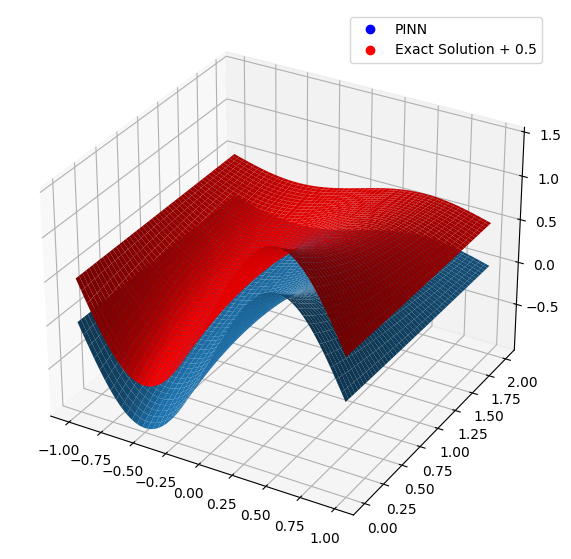

In [105]:
import matplotlib as mpl

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, z)
ax.plot_surface(x, t, z2+0.5, color='r')



fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)



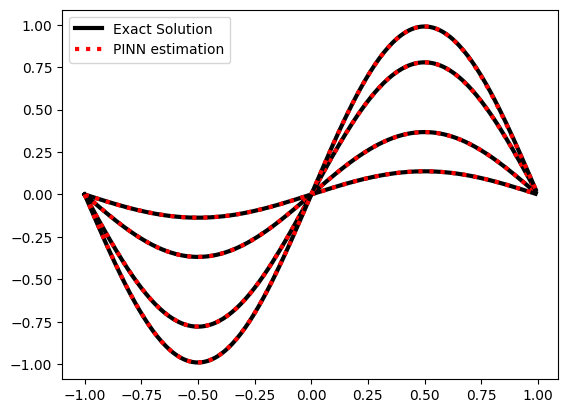

In [141]:
fig, ax = plt.subplots()
l1 = ax.plot(x1,sol2[100], c="k", linewidth=3)
l2 = ax.plot(x1,sol1[100], c="r", linestyle='dotted', linewidth=3)
l3 = ax.plot(x1,sol2[25], c="k", linewidth=3)
l4 = ax.plot(x1,sol1[25], c="r", linestyle='dotted', linewidth=3)
l5 = ax.plot(x1,sol2[199], c="k", linewidth=3)
l6 = ax.plot(x1,sol1[199], c="r", linestyle='dotted', linewidth=3)
l7 = ax.plot(x1,sol2[1], c="k", linewidth=3)
l8 = ax.plot(x1,sol1[1], c="r", linestyle='dotted', linewidth=3)
plt.legend(["Exact Solution","PINN estimation"])
plt.show()